# Quantum data

Expanding on this fascinating exploration of quantum versus classical machine learning, this project dives into recent advances in understanding the capabilities and limitations of quantum models compared to their classical counterparts. Building on the foundational concepts introduced in the [MNIST](https://www.tensorflow.org/quantum/tutorials/mnist) project, this guide examines the findings of [Huang et al.](https://arxiv.org/abs/2011.01938), which highlight how the choice of dataset can influence the comparative performance between quantum and classical models. In their study, the authors investigate the scenarios where classical machine learning (ML) models can achieve similar—or even superior—performance to quantum models, depending on specific dataset characteristics. They also establish a clear empirical performance gap between classical and quantum ML models by utilizing a meticulously designed dataset, underscoring how the right data can amplify quantum models' advantages.

This project will guide you through the following steps to demonstrate these comparisons in practice:

1. **Preparing a Reduced-Dimension Fashion-MNIST Dataset**: We start by transforming the Fashion-MNIST dataset to reduce its dimensionality, creating a more computationally manageable dataset that retains essential patterns. This preprocessing step allows us to test quantum and classical models more effectively by focusing on core features without overwhelming computational resources.

2. **Applying Quantum Circuits for Re-Labeling and Computing Projected Quantum Kernel (PQK) Features**: In this step, quantum circuits will be used to re-label the dataset, introducing a quantum dimension through Projected Quantum Kernel (PQK) features. The PQK features act as quantum-generated representations that capture data patterns in ways classical models may struggle to replicate, enabling a fresh lens through which to view the dataset.

3. **Training and Comparison**: Finally, we train a classical neural network on the re-labeled dataset and assess its performance relative to a model trained with access to PQK features. By comparing these models, we aim to evaluate the added value that quantum-derived features bring to classical learning, offering insights into the nuanced dynamics between quantum and classical performance.

This project not only demonstrates technical methods but also encourages a deeper understanding of when and why quantum models might excel, especially when combined with innovative data representations like PQK. By the end, you'll gain a clearer perspective on how quantum and classical models intersect and diverge across different datasets and experimental setups, enriching the broader conversation on the practical advantages of quantum machine learning.

# Setup

In [1]:
!pip install tensorflow==2.15.0 tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 598.8/598.8 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: sympy
    Found existing installation: sy

In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [3]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(0)

# Data preparation

You will begin by preparing the fashion-MNIST dataset for running on a quantum computer.

## Download fashion-MNIST

The first step is to get the traditional fashion-mnist dataset. This can be done using the `tf.keras.datasets` module.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

4422102/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the T-shirts/tops and dresses, remove the other classes. At the same time convert the label, `y`, to boolean: True for 0 and False for 3.

In [5]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [6]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


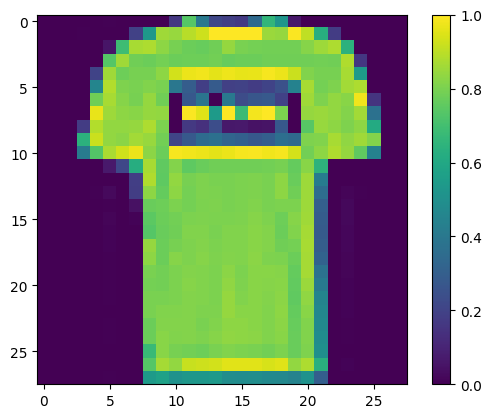

In [8]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()
plt.show()

This image is a grayscale representation of an item from the Fashion-MNIST dataset, specifically depicting a T-shirt or top. The Fashion-MNIST dataset is a popular dataset used in machine learning and computer vision, containing images of various clothing items. Here’s a detailed explanation of the components in this image:

1. **Image Content**:
   - The item shown appears to be a T-shirt, one of the categories in the Fashion-MNIST dataset. This category is labeled as "0" in the dataset.

2. **Pixel Grid (28x28)**:
   - The image consists of a **28x28** pixel grid, which is the standard resolution for images in the Fashion-MNIST dataset.
   - Each pixel value is normalized between 0 and 1, with **0** representing the darkest (black) and **1** representing the brightest (white). Intermediate values represent different shades of gray.

3. **Color Map**:
   - The color bar on the right shows the range of pixel intensities, with purple representing lower intensity values (closer to 0) and yellow representing higher intensity values (closer to 1).
   - In this plot, the majority of the T-shirt is a greenish color, indicating intermediate intensity values, while the edges and some areas inside the T-shirt are closer to yellow, indicating brighter parts of the image.

4. **Structure**:
   - You can see the basic structure of a T-shirt with a collar, sleeves, and body in the image. The outline and certain details are visible due to the variations in pixel intensity, which correspond to different shades of gray.
   - These features are distinguishable despite the low resolution, making it feasible for a machine learning model to classify it as a T-shirt.

5. **Normalization**:
   - This image is normalized, which is a typical preprocessing step in machine learning. Normalization scales pixel values to a range (in this case, 0 to 1) to make it easier for models to learn from the data.

***Purpose in Machine Learning***
This image would be one of the samples used for training or testing a classification model on Fashion-MNIST. The goal of such a model would be to correctly classify images into categories like T-shirts, trousers, coats, and other types of clothing. The simple structure and distinct shape make T-shirts easier to classify compared to other, more intricate clothing items in the dataset.

This visualization is a useful way to inspect the dataset and understand how images appear after preprocessing, ensuring they are ready for model training and evaluation.

## Downscale the images

Just like the MNIST example, you will need to downscale these images in order to be within the boundaries for current quantum computers. This time however you will use a PCA transformation to reduce the dimensions instead of a `tf.image.resize` operation.

In [ ]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(tf.einsum('ji,jk->ik',
                                                 x_train_normalized,
                                                 x_train_normalized))

  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

In [ ]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))

New datapoint dimension: 10


The last step is to reduce the size of the dataset to just 1000 training datapoints and 200 testing datapoints.

In [ ]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

In [ ]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


# Relabeling and computing PQK features

You will now prepare a "stilted" quantum dataset by incorporating quantum components and re-labeling the truncated fashion-MNIST dataset you've created above. In order to get the most seperation between quantum and classical methods, you will first prepare the PQK features and then relabel outputs based on their values.

## Quantum encoding and PQK features

You will create a new set of features, based on `x_train`, `y_train`, `x_test` and `y_test` that is defined to be the 1-RDM on all qubits of:

$V(x_{\text{train}} / n_{\text{trotter}}) ^ {n_{\text{trotter}}} U_{\text{1qb}} | 0 \rangle$

Where $U_\text{1qb}$ is a wall of single qubit rotations and $V(\hat{\theta}) = e^{-i\sum_i \hat{\theta_i} (X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1})}$

First, you can generate the wall of single qubit rotations:

In [ ]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit

You can quickly verify this works by looking at the circuit:

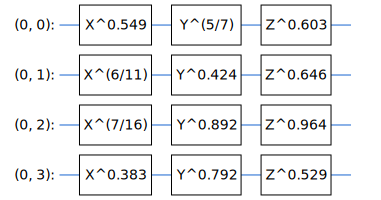

In [ ]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

This image is a visual representation of quantum gate operations applied to a qubit in a circuit, with each row representing a different set of gate operations on a qubit at various stages.

Here's a breakdown of what each element means:

1. **Grid Coordinates (Left Column)**: The coordinates on the left, like `(0, 0)`, `(0, 1)`, etc., may indicate the position of each qubit in a grid-like arrangement, possibly part of a multi-qubit system. This notation suggests that each row represents a specific qubit in the quantum system and the sequence of operations applied to it.

2. **Quantum Gates**:
   - `X^a`, `Y^b`, and `Z^c` represent rotations along the X, Y, and Z axes, respectively.
   - For example, `X^0.549` means a rotation around the X-axis by a certain angle proportional to `0.549`. Similarly, `Y^(5/7)` and `Z^0.603` indicate rotations around the Y and Z axes by corresponding angles.
   
   These rotations are often parameterized by angles (here represented by the numbers next to each gate) and are used in quantum circuits to manipulate the qubit's state.

3. **Values**:
   - Each gate has a specific exponent value. For instance:
     - `(0, 0)`: `X^0.549`, `Y^(5/7)`, `Z^0.603`
     - `(0, 1)`: `X^(6/11)`, `Y^0.424`, `Z^0.646`
   - These values specify how much the qubit's state should be rotated around each respective axis, which is crucial in configuring the qubit to achieve desired quantum states.

4. **Purpose of the Operations**:
   - Applying different rotations to each qubit can create superpositions, entangle qubits, or prepare the qubits in specific quantum states for further processing. In many quantum algorithms, such parameterized rotations are used to adjust the qubits based on the data or the desired outcome of the computation.

5. **Structure**:
   - The structure suggests a layered application of gates on each qubit, with each row showing a sequence of operations for a particular qubit in the circuit. This is common in variational quantum circuits, where qubit states are tuned iteratively for optimization tasks.

In summary, this image represents the operations of a parameterized quantum circuit where different qubits are rotated along various axes by specific angles, a process often seen in quantum machine learning or optimization tasks.

Next you can prepare $V(\hat{\theta})$ with the help of `tfq.util.exponential` which can exponentiate any commuting `cirq.PauliSum` objects:

In [ ]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

This circuit might be a little bit harder to verify by looking at, but you can still examine a two qubit case to see what is happening:

Symbols found in circuit:[ref_0]


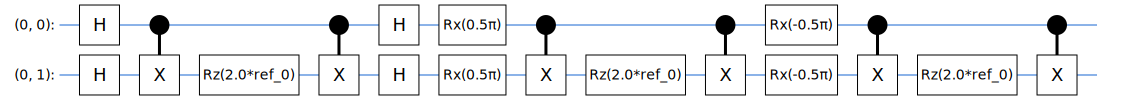

In [ ]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

This image represents a quantum circuit involving two qubits, labeled as `(0, 0)` and `(0, 1)`, and illustrates the sequence of operations applied to each qubit. Let’s go through the components step by step:

1. **Qubits (0, 0) and (0, 1)**:
   - Each row corresponds to a qubit in the circuit. The operations on each row apply to that particular qubit.

2. **Hadamard Gates (`H`)**:
   - The `H` gate is applied at various points in the circuit, creating superpositions by transforming the qubit from a basis state (|0⟩ or |1⟩) into an equal superposition of both states. This gate is commonly used in quantum circuits to enable interference effects by putting qubits into a balanced superposition.

3. **Controlled-X (CNOT) Gates**:
   - The black circle connected to an "X" gate represents a controlled-X (CNOT) gate. The CNOT gate applies the `X` (or NOT) operation to the target qubit (the qubit with "X" on it) only if the control qubit (the qubit with the black dot) is in the |1⟩ state.
   - In this circuit, the CNOT gates are used to create entanglement between the two qubits, establishing a dependency in their states.

4. **Rotation Gates (`Rz` and `Rx`)**:
   - `Rz(2.0 * ref_0)`: The `Rz` gate applies a rotation around the Z-axis by an angle determined by the expression `(2.0 * ref_0)`. This parameter might be a variable used to adjust the angle dynamically.
   - `Rx(0.5π)` and `Rx(-0.5π)`: The `Rx` gate applies a rotation around the X-axis by either `0.5π` or `-0.5π`. These rotations change the probability amplitudes of the qubit's state, contributing to the evolution of the quantum state in a way that is sensitive to the parameters chosen.

5. **Sequence of Operations**:
   - The circuit starts with Hadamard gates on both qubits, putting them into superposition.
   - A controlled-X gate is applied to entangle the two qubits.
   - An `Rz` gate with a parameterized rotation, followed by additional Hadamard gates and `Rx` rotations, further modifies the qubits.
   - The controlled-X gates interspersed throughout continue to entangle and disentangle the qubits as the circuit progresses.
   - This pattern of Hadamard, rotation, and controlled operations is often used in quantum algorithms for tasks that require controlled interference, entanglement, and parameterized adjustments.

6. **Purpose**:
   - This circuit design suggests that it could be part of a parameterized quantum algorithm or a variational quantum circuit. The use of `Rx` and `Rz` rotations with specific parameters and the inclusion of CNOT gates imply a setup where the qubits are prepared in a specific state, possibly for a quantum machine learning application, optimization, or variational task.

In summary, this quantum circuit employs a combination of superposition (Hadamard gates), entanglement (CNOT gates), and parameterized rotations (`Rx` and `Rz` gates) to prepare a specific quantum state for further processing or measurement. The presence of adjustable parameters (`ref_0`) indicates that this circuit may be designed to adapt to different inputs or optimization steps.

Now you have all the building blocks you need to put your full encoding circuits together:

In [ ]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

Choose some qubits and prepare the data encoding circuits:

In [ ]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

Next, compute the PQK features based on the 1-RDM of the dataset circuits above and store the results in `rdm`, a `tf.Tensor` with shape `[n_points, n_qubits, 3]`. The entries in `rdm[i][j][k]` = $\langle \psi_i | OP^k_j | \psi_i \rangle$ where `i` indexes over datapoints, `j` indexes over qubits and `k` indexes over $\lbrace \hat{X}, \hat{Y}, \hat{Z} \rbrace$ .

In [ ]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

In [ ]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


## Re-labeling based on PQK features

Now that you have these quantum generated features in `x_train_pqk` and `x_test_pqk`, it is time to re-label the dataset. To achieve maximum seperation between quantum and classical performance you can re-label the dataset based on the spectrum information found in `x_train_pqk` and `x_test_pqk`.

In preparing your dataset specifically to amplify the performance gap between classical and quantum models, you may feel as though you're "gaming the system" or setting up an unfair advantage for quantum computing. However, this approach serves an essential purpose in the field of Quantum Machine Learning (QML): it offers a crucial proof of existence for datasets that are inherently challenging for classical models but more manageable for quantum models.

The existence of such datasets is fundamental because it provides a concrete demonstration that quantum models can indeed exhibit a measurable advantage under certain conditions. If we could not construct or identify data that highlights this separation, it would be difficult to justify the pursuit of quantum advantage in QML applications. This process allows researchers to explore the boundaries of what quantum systems can achieve in comparison to classical systems, enabling us to understand when and why quantum models might outperform classical alternatives.

Creating and testing on these purposefully challenging datasets is not about skewing results in favor of quantum models; rather, it's about paving the way for real-world applications of quantum advantage. By starting with well-defined, advantageous scenarios, we gain insights into the unique capabilities of quantum systems. These insights can then inform more complex and practical applications, where the potential advantages of quantum models might not be as obvious but could still offer significant value in specific fields.

In essence, this approach is about setting a baseline and showcasing the strengths of quantum models in a controlled environment. Once a clear advantage is demonstrated with purpose-built datasets, researchers can move towards testing quantum models on more diverse and real-world data, gradually advancing toward applications where quantum computing could offer transformative benefits over classical approaches. This structured, proof-driven progression is critical for establishing the viability and future direction of Quantum Machine Learning.

In [ ]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [ ]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[-0.00868077  0.02423258  0.01467333 ...  0.01395902 -0.0050917
   0.02220657]
 [-0.02525454  0.01181304 -0.05881315 ...  0.0014556   0.01359901
   0.03266412]
 [-0.01401961 -0.02108116 -0.01923301 ...  0.00437862 -0.01515722
   0.02846662]
 ...
 [ 0.04236531 -0.01111557 -0.01225703 ...  0.04084962 -0.12148073
   0.02641368]
 [ 0.05043699  0.0106735  -0.03753379 ... -0.10222666  0.06217318
   0.03121907]
 [ 0.06210106 -0.01802788  0.00602458 ...  0.          0.
   0.03108444]], shape=(1200, 1200), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[ 0.03835682 -0.0283473  -0.01169783 ... -0.00157049 -0.03562555
   0.03206971]
 [-0.04018167 -0.00888094 -0.01388247 ... -0.02960675  0.01823647
   0.0288196 ]
 [-0.01667189 -0.01350371 -0.0366386  ... -0.02697806  0.01625295
   0.02195407]
 ...
 [-0.03015643  0.01671633 -0.01603425 ...  0.02381248  0.19260113
   0.02365687]
 [ 0.00397763  0.04998881 -0.00528352 ...  0.09188147 -

Now you have everything you need to re-label the dataset! Now you can consult with the flowchart to better understand how to maximize performance seperation when re-labeling the dataset:

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/quantum_data_1.png?raw=1">

In order to maximize the seperation between quantum and classical models, you will attempt to maximize the geometric difference between the original dataset and the PQK features kernel matrices $g(K_1 || K_2) = \sqrt{ || \sqrt{K_2} K_1^{-1} \sqrt{K_2} || _\infty}$ using `S_pqk, V_pqk` and `S_original, V_original`. A large value of $g$ ensures that you initially move to the right in the flowchart down towards a prediction advantage in the quantum case.

Note: Computing quantities for $s$ and $d$ are also very useful when looking to better understand performance seperations. In this case ensuring a large $g$ value is enough to see performance seperation.

In [ ]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [ ]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

# Comparing models

Now that you have prepared your dataset it is time to compare model performance. You will create two small feedforward neural networks and compare performance when they are given access to the PQK features found in `x_train_pqk`.

## Create PQK enhanced model

Using standard `tf.keras` library features you can now create and a train a model on the `x_train_pqk` and `y_train_new` datapoints:

In [ ]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1088      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This output describes the architecture of a simple feedforward neural network model in TensorFlow/Keras, using the "Sequential" API, which allows stacking layers in a linear sequence. Here’s a breakdown of each component in the model summary:

1. **Model Type**:
   - The model is of type **"sequential"**, meaning the layers are stacked one after the other in a sequence.

2. **Layers**:
   - The network consists of three **Dense** (fully connected) layers, each with a specified number of units (neurons) and parameters.

3. **Layer Details**:
   - **Layer 1 (dense)**:
     - **Units**: 32
     - **Output Shape**: `(None, 32)`, where `None` indicates that the batch size is variable, and 32 represents the number of units in this layer.
     - **Parameters**: 1088 parameters, calculated as `(input_features + 1) * 32` (where the +1 accounts for the bias term in each neuron).
   - **Layer 2 (dense_1)**:
     - **Units**: 16
     - **Output Shape**: `(None, 16)`
     - **Parameters**: 528, calculated as `(32 + 1) * 16`, connecting the 32 units from the previous layer to 16 units in this layer.
   - **Layer 3 (dense_2)**:
     - **Units**: 1 (output layer)
     - **Output Shape**: `(None, 1)`, indicating a single output value.
     - **Parameters**: 17, calculated as `(16 + 1) * 1`, where 16 inputs connect to 1 output neuron, with an additional bias term.

4. **Parameter Summary**:
   - **Total Parameters**: 1,633, which includes all the weights and biases across the layers.
   - **Trainable Parameters**: 1,633, meaning all parameters will be adjusted during training.
   - **Non-trainable Parameters**: 0, indicating there are no frozen layers or fixed parameters in this model.

5. **Total Size**:
   - The entire model occupies 6.38 KB, which is relatively lightweight and should be efficient for training on smaller datasets or for deployment in low-resource environments.

This model could be suitable for a binary classification or regression task, given the single neuron in the output layer. It’s relatively simple, which might make it appropriate for tasks with limited complexity or small datasets.

In [ ]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

## Create a classical model

Similar to the code above you can now also create a classical model that doesn't have access to the PQK features in your stilted dataset. This model can be trained using `x_train` and `y_label_new`.

In [ ]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                352       
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 897 (3.50 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This output describes a smaller, sequential neural network model compared to the previous example. Here’s a breakdown of its architecture and parameter details:

1. **Model Type**:
   - The model is of type **"sequential"**, meaning layers are stacked in a linear sequence.

2. **Layers**:
   - The model consists of three **Dense** (fully connected) layers, with a specific number of units (neurons) in each layer and a set of trainable parameters.

3. **Layer Details**:
   - **Layer 1 (dense_3)**:
     - **Units**: 32
     - **Output Shape**: `(None, 32)`, where `None` is for the variable batch size, and 32 represents the number of neurons in this layer.
     - **Parameters**: 352, calculated as `(input_features + 1) * 32`. The number of input features is inferred to be 10 here because \( (10 + 1) \times 32 = 352 \).
   - **Layer 2 (dense_4)**:
     - **Units**: 16
     - **Output Shape**: `(None, 16)`
     - **Parameters**: 528, calculated as `(32 + 1) * 16`, connecting the 32 units from the previous layer to 16 units in this layer.
   - **Layer 3 (dense_5)**:
     - **Units**: 1 (output layer)
     - **Output Shape**: `(None, 1)`, which represents a single output value.
     - **Parameters**: 17, calculated as `(16 + 1) * 1`, where 16 inputs connect to 1 output neuron with an additional bias term.

4. **Parameter Summary**:
   - **Total Parameters**: 897, which includes all weights and biases across the layers.
   - **Trainable Parameters**: 897, meaning all parameters will be updated during training.
   - **Non-trainable Parameters**: 0, indicating no fixed parameters in this model.

5. **Total Size**:
   - The model is relatively lightweight, occupying just 3.50 KB, making it suitable for simpler tasks or environments with limited resources.

This network is designed to be smaller and simpler than the previous model. With only 897 parameters, it may be suitable for tasks requiring limited model complexity, such as binary classification or regression on smaller datasets or datasets with low-dimensional input features.

In [ ]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))

## Compare performance

After training the two models, it’s time to assess their performance, especially on validation data where generalization ability is tested. While both models are likely to achieve high accuracy—above 0.9—on the training data, this high training accuracy often does not directly translate to strong generalization on unseen instances in the validation data.

To highlight the differences, you can plot the validation accuracy for both models side by side. This comparison will demonstrate how the inclusion of **Projected Quantum Kernel (PQK) features** can affect generalization. PQK features are derived from a quantum-enhanced data representation, which often captures more complex patterns in the data that traditional, purely classical representations may overlook. This unique characteristic can give quantum models a significant advantage on validation data, as they leverage richer data representations to recognize patterns in unseen samples.

Here's what to expect in the performance plot:

1. **Training Accuracy**:
   - Both models are likely to exceed 90% accuracy on the training set, given that they are well-fitted to the data provided. This high training accuracy suggests that both models can learn the given patterns within the training dataset effectively.
   
2. **Validation Accuracy**:
   - On the validation set, the differences between the two models become apparent. The classical model, which lacks access to PQK features, may experience a noticeable drop in performance. This decrease reflects a limitation in the model’s ability to generalize beyond the training data. In contrast, the model trained with PQK features, which are crafted to capture intricate data structures, should retain a much higher accuracy on the validation set. The PQK features allow the quantum-enhanced model to better understand complex relationships and dependencies in the data, even when faced with instances it hasn’t seen before.

3. **Visualizing the Performance Gap**:
   - By plotting validation accuracy over epochs for both models, you’ll observe the classical model plateauing or potentially even declining in performance on the validation set due to overfitting. Meanwhile, the model leveraging PQK features is expected to maintain more stable and higher validation accuracy, indicating stronger generalization.
   
4. **Implications of the PQK Features**:
   - The difference in validation accuracy highlights the unique benefits of PQK features. Since these features encapsulate a richer, quantum-informed representation of the data, they allow the model to distinguish between patterns that are hard for classical models to identify. This performance gap serves as a practical demonstration of quantum advantage in machine learning: while the classical model may struggle with unseen data, the quantum-enhanced model remains resilient, adapting more effectively to new instances.

In summary, this comparison underscores the importance of PQK features in enabling a model to generalize well to unseen data. By plotting the validation performance of both models, you can clearly see that while classical models may perform well on training data, only the information provided by PQK features allows for robust performance on validation data. This validation gap provides evidence of the potential advantage of quantum machine learning models in specific tasks, setting the stage for their application in real-world problems where generalization is critical.

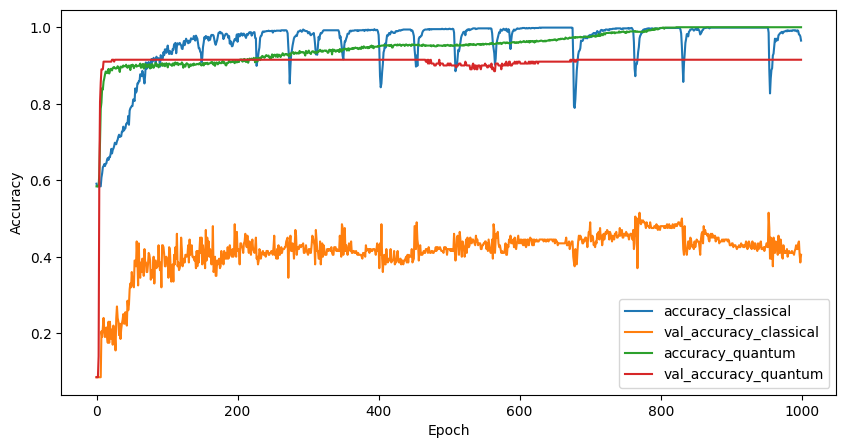

In [ ]:
#docs_infra: no_execute
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

This plot shows the accuracy of multiple models over 1000 training epochs. Here’s a breakdown of what each line likely represents and what the plot indicates about the performance and generalization of the models:

1. **Axes**:
   - The x-axis represents the **Epochs**, or the number of training cycles the models have gone through.
   - The y-axis shows **Accuracy**, with values ranging from 0 to 1, where 1 represents 100% accuracy.

2. **Lines and Colors**:
   - There are four distinct colored lines representing the accuracy curves of different models or different datasets (training vs. validation) across epochs:
     - **Blue Line**: This line shows a model that achieves high accuracy but exhibits noticeable fluctuations. The dips in accuracy suggest potential instability or overfitting. This could be a classical model struggling to generalize to validation data, causing it to perform inconsistently on unseen instances.
     - **Green Line**: This line is stable and reaches a high level of accuracy, close to 1.0, without the fluctuations seen in the blue line. This could represent a quantum-enhanced model using PQK features, which helps it generalize well without overfitting.
     - **Red Line**: This line is relatively flat and stable, possibly representing the training or baseline performance of a simpler model or a classical model without PQK features. Its accuracy seems to plateau early and remains consistent without achieving high accuracy, indicating limited learning ability.
     - **Orange Line**: This line has the lowest accuracy and fluctuates throughout the epochs, likely representing a poorly performing model that fails to learn effectively. It could represent a classical model without access to any enhanced features, struggling to find useful patterns in the data.

3. **Insights and Interpretations**:
   - **Blue Line Instability**: The fluctuations in the blue line might be due to overfitting or instability in training. Despite achieving high accuracy at times, the model may not generalize well, leading to performance drops on validation data.
   - **Green Line Generalization**: The green line likely represents a model that can generalize effectively to unseen data, as it maintains high accuracy without significant fluctuations. This stability could be due to the PQK features, allowing the model to capture complex patterns that improve its resilience on new data.
   - **Red Line Plateau**: The red line reaches an early plateau, indicating a simpler model or a model without access to advanced features like PQK. It shows limited improvement over time, likely due to the lack of information in the data representation.
   - **Orange Line Struggles**: The low and inconsistent accuracy of the orange line suggests that the model is unable to learn the patterns effectively. This could be a baseline classical model with minimal data features, struggling due to the dataset’s complexity.

4. **Overall Analysis**:
   - This plot illustrates the impact of feature quality on model performance. Models with PQK features (likely the green line) show higher, stable accuracy, indicating that quantum-enhanced representations improve generalization to validation data.
   - The fluctuating and lower-performing lines (blue, red, and orange) likely represent classical models without PQK features, which struggle to maintain consistent accuracy on validation data.
   - This performance gap underscores the advantages of quantum machine learning models in scenarios where complex data structures are challenging for classical approaches.

In conclusion, the plot visually confirms that the model trained with PQK features (green line) achieves both high accuracy and generalization, while classical models without these features show limited or unstable performance on validation data. This serves as a practical demonstration of the potential advantage that quantum features can provide in machine learning tasks.

# Important conclusions

The experiments conducted here and in the [MNIST Quantum ML tutorial](https://www.tensorflow.org/quantum/tutorials/mnist) provide several key insights into the current state of quantum versus classical machine learning. These conclusions shed light on the strengths, limitations, and potential of quantum models when applied to different types of data, particularly in relation to the limitations of classical models. Here’s an expanded discussion of each point:

1. **Quantum Models Are Unlikely to Outperform Classical Models on Large Classical Datasets**:
   - One of the most important takeaways from these experiments is the realization that today’s quantum models are unlikely to surpass classical models when working with traditional, large-scale classical datasets. Classical datasets, especially those used in modern machine learning, often consist of millions of datapoints and complex feature representations. Classical models have been optimized over decades to handle such data efficiently and accurately.
   - Quantum machine learning is still in its infancy, with current quantum computers having limited qubit counts, coherence times, and error rates. This makes it challenging for quantum models to handle datasets of similar scale or complexity effectively. Thus, in practical terms, classical models remain the go-to solution for large, conventional datasets where they have proven to be both efficient and powerful.

2. **Quantum Origin of Data Doesn’t Necessarily Imply Difficulty for Classical Models**:
   - Another key insight is that just because data originates from a quantum system or a complex quantum circuit, it doesn’t automatically make that data difficult for classical models to learn. Many classical models can approximate complex functions, even those derived from quantum circuits, especially when the underlying patterns in the data aren’t highly entangled or aren’t structured in ways that classical models can’t effectively capture.
   - This understanding is crucial in shaping expectations around quantum advantage. Just because data is generated or inspired by a quantum process doesn’t mean it inherently requires a quantum model to achieve high accuracy. Classical models, particularly deep neural networks, have a remarkable ability to approximate a wide range of functions, and they often perform well on quantum-generated data unless it’s specifically designed to exploit the unique capabilities of quantum systems.

3. **Existence of Quantum-Advantage Datasets**:
   - Perhaps the most promising conclusion from these experiments is the empirical demonstration that certain types of datasets do exist that are easy for quantum models to learn and difficult for classical models. These datasets, inherently quantum in nature, exhibit structures that are challenging for classical architectures and algorithms to capture, regardless of their complexity or scale.
   - Identifying and working with these datasets is a foundational step in demonstrating quantum advantage in machine learning. These quantum-specific datasets provide evidence that, under the right conditions, quantum models can achieve results that classical models cannot, opening the door to applications where quantum advantage is not just theoretical but practical. This finding justifies further exploration into quantum machine learning, as it hints at future possibilities where quantum models may offer unique solutions to complex real-world problems that classical models cannot easily address.

***Broader Implications for Quantum Machine Learning***

These conclusions underscore the current and potential future role of quantum machine learning. While classical models are likely to retain their dominance on conventional datasets, the ability of quantum models to outperform classical ones on certain quantum-specific datasets suggests that quantum machine learning could carve out specialized niches. This could be particularly valuable in fields where data is inherently quantum, such as quantum chemistry, materials science, and some areas of cryptography, where quantum-native data might be better suited to quantum analysis.

Moreover, these insights highlight the importance of dataset design and selection in quantum machine learning research. The search for quantum advantage is not solely about improving quantum hardware or optimizing quantum algorithms—it’s also about identifying datasets that inherently challenge classical models. By designing and studying such datasets, researchers can showcase quantum advantage more effectively, providing a clearer path for practical quantum applications.

In summary, these experiments reinforce the idea that quantum machine learning is not a replacement for classical machine learning but rather a complementary tool. Classical models will continue to perform well on large, traditional datasets, while quantum models offer potential advantages on specific quantum-native datasets. As the field progresses, this hybrid approach—leveraging classical and quantum models in tandem or selectively—may become the most practical way forward in realizing the full potential of machine learning in diverse domains.